# Pre-Modelling Analysis of a Data Set
This notebook provides a walk-through of the standard analysis done before modelling a binary target. The purpose of this analysis is to get familiar with the data set, clean up the features, and get an initial understanding of the features associated with the target.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Local packages
import stats

# Set up formatting
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('ggplot')

In [3]:
# Load data
example_df = pd.read_csv('bank.csv', na_values=[np.nan])

# Print high-level summary of the data frame
stats.df_stats(example_df)

# Preview data
print('\nPreview of Data:')
print(example_df.head(1))
# print(example_df.tail(1))

The data set contains 10578 rows and 19 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10578 entries, 0 to 10577
Data columns (total 19 columns):
Unnamed: 0     10578 non-null int64
ID             10578 non-null int64
Age_2          10578 non-null int64
Balance_2      10578 non-null int64
Day_2          10578 non-null int64
Duration_2     10578 non-null int64
Campaign_2     10578 non-null int64
Pdays_2        10578 non-null int64
Previous_2     10578 non-null int64
Y_2            10578 non-null int64
Month_2        10578 non-null int64
Education_2    10578 non-null int64
Marital_2      10578 non-null int64
Job_2          10578 non-null int64
Default_2      10578 non-null int64
Loan_2         10578 non-null int64
Contact_2      10578 non-null int64
Poutcome_2     10578 non-null int64
Housing_2      10578 non-null int64
dtypes: int64(19)
memory usage: 1.5 MB
None

Preview of Data:
   Unnamed: 0      ID  Age_2  Balance_2  Day_2  Duration_2  Campaign_2  \
0           1  122482 

## Clean-up features

In [4]:
# Drop features that are not meaningful for the analysis
drop_elements = ['ID', 'Unnamed: 0']
example_df = example_df.drop(drop_elements, axis=1)

# Group features by data types
categorical_cols = ['Marital_2', 'Education_2']
numerical_cols = [col for col in example_df.columns if col not in categorical_cols]

# Basic NA cleaning
example_df.fillna({x: 'unknwn' for x in categorical_cols}, inplace=True)
example_df.fillna({x: -1 for x in numerical_cols}, inplace=True)

# Correct dtypes
for col in categorical_cols:
    example_df[col] = example_df[col].astype(np.object)
for col in numerical_cols:
    example_df[col] = example_df[col].astype(np.float)

print('Corrected Data Types:\n{}'.format(example_df.dtypes))

# Review target
target = example_df['Y_2']
print('\nTarget Summary:')
stats.analyse_target(target=target)

# Review key stats for features
print('\nFeature Summary:')
print(example_df.describe(include='all'))

# Review NA values
data_na = stats.count_na(example_df)
print('\nMissing values:')
print(data_na)

# Drop features with > 90% missing
high_na = data_na.loc[data_na['Percent'] > 0.9].index.tolist()
print('\nFeatures with > 90% missing values to be dropped: {}'.format(len(high_na)))
example_df = example_df.drop(high_na, axis=1)

# Group infrequent values in categorical features to 'other' for visualisation
example_df = stats.clean_cats(example_df)

Corrected Data Types:
Age_2          float64
Balance_2      float64
Day_2          float64
Duration_2     float64
Campaign_2     float64
Pdays_2        float64
Previous_2     float64
Y_2            float64
Month_2        float64
Education_2     object
Marital_2       object
Job_2          float64
Default_2      float64
Loan_2         float64
Contact_2      float64
Poutcome_2     float64
Housing_2      float64
dtype: object

Target Summary:
       count  percent
2.000   5289    0.500
1.000   5289    0.500

Feature Summary:
           Age_2  Balance_2     Day_2  Duration_2  Campaign_2   Pdays_2  \
count  10578.000  10578.000 10578.000   10578.000   10578.000 10578.000   
unique       nan        nan       nan         nan         nan       nan   
top          nan        nan       nan         nan         nan       nan   
freq         nan        nan       nan         nan         nan       nan   
mean      41.133   1548.530    15.476     379.244       2.475    -0.336   
std       12.144   313

## Review relationships in data

#### Compare Numerical Features using Correlation
Correlation measures the linear (straight line) relationship between two numerical features. The correlation coefficienct measures the strength and direction of that linear relationship, with values ranging from -1 to 1. A negative coefficient indicates a negative relationship (as one goes up, the other goes down), whereas a positive coefficient indicates a positive relationship (as one goes up, so does the other). The closer the correlation co-efficient is to 1 or -1, the stronger the relationship. 

In [5]:
# Numerical vs Numerical Features - Correlation

high_corr_df = stats.correlated_features(df=example_df, min_corr=0.85, target_col_str='Y_2')
high_corr_unique_f = list(set(high_corr_df['feature 1'].unique().tolist()
                              + high_corr_df['feature 2'].unique().tolist()))

print('Number of highly correlated features: {}'.format(len(high_corr_unique_f)))
print(high_corr_unique_f)

Number of highly correlated features: 2
['Poutcome_2', 'Pdays_2']


If you have a high number of features (100's or 1000's), a quick way to reduce dimensionality is to remove numerical features that are highly correlated with other numerical features. Below is a quick solution, but you could also use the strength of the relationship with the target to decide which features to keep.

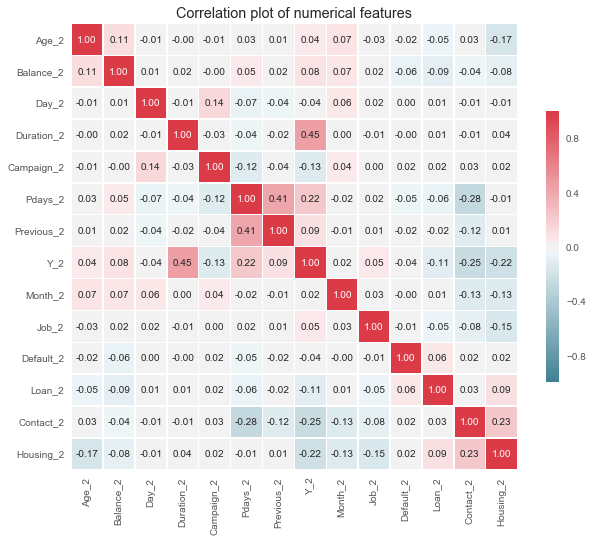

In [7]:
# Quick solution to reduce correlated features - drop the 2nd feature

high_corr_f2 = high_corr_df['feature 2'].unique().tolist()
example_df = example_df.drop(high_corr_f2, axis=1)

# Plot correlations between remaining features

f, ax = plt.subplots(figsize=(10, 10))
correlations = stats.correlation_plot(example_df, ax=ax)
plt.show()

#### Compare Numerical features to Target

The point bi-serial correlation coeficient compares numerical features to a dichotomous target. As before, the values vary from -1 to 1, and the closer the value is to 1 or -1, the stronger the linear relationship

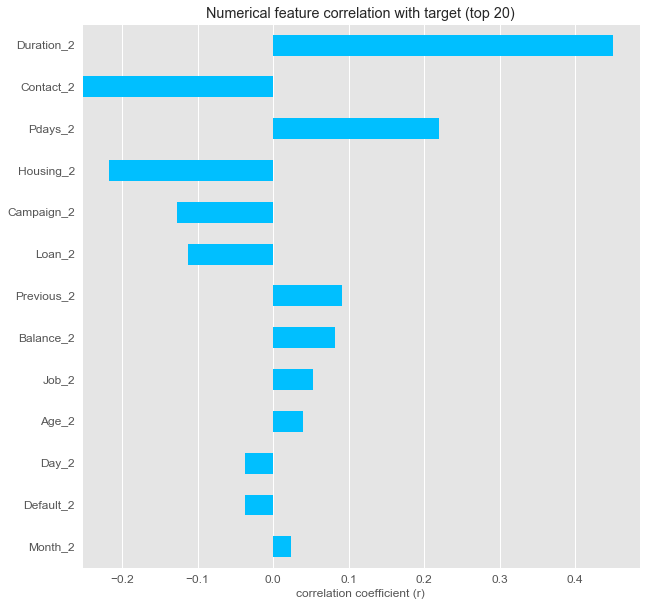

In [8]:
# Remaining Numerical Features vs Categorical Target

pbs_corr = stats.point_biserial_corr(df=example_df, target_col_str='Y_2')
title = 'Numerical feature correlation with target (top 20)'
score_label = 'correlation coefficient (r)'

stats.plot_score(df=pbs_corr, score_col='corr', n=20, title=title, log_scale=False, score_label=score_label)

#### Visual Analysis

The below plots the distribution of each numerical feature, as well as the distribution by the target. Visually analysing the features can help you better understand the data and identify data issues such as outliers.

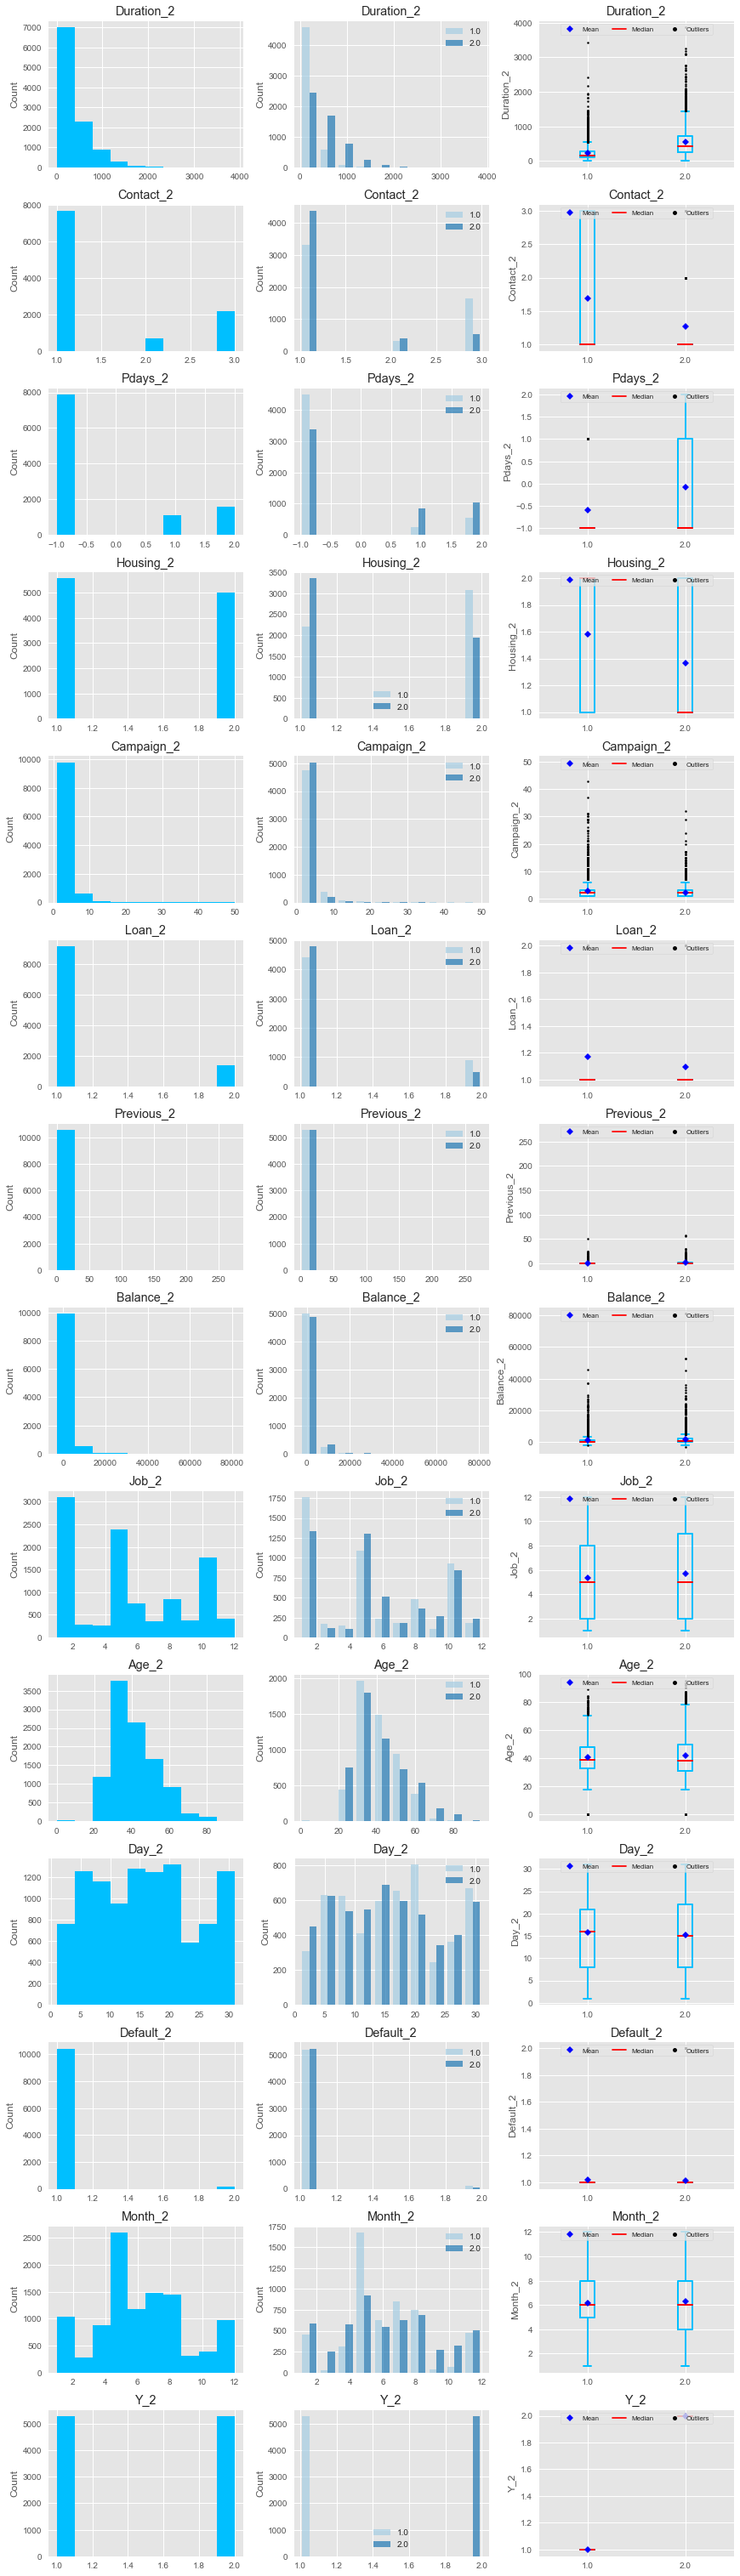

In [9]:
# Visual analysis of Top Numerical Features vs Target

top_numerical_f = pbs_corr.sort_values(by='corr_abs', ascending=False)[0:20].index.tolist()
top_numerical_f.append('Y_2')
numerical_df_p = example_df[top_numerical_f]
stats.plot_features(df=numerical_df_p, target_col_str='Y_2')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

#### Compare Categorical Features to Target

The chi-squared test is used to test an association between each categorical feature and the target. The test calculates the expected counts (what they would be if the feature and target were indpendent) for each cell in a crosstab (E = row total * column total / sample size) and compares them to the observed counts. The p-value is the probability of seeing a difference at least as extreme as the result observed. If the p-value is low (<0.05) we reject the null hypothesis (no association) and conclude that it is unlikely there is no association between the feature and the target


Chi-squared Test for Independence:
Ho: No significant relationship, feature is independent of target

Features tested: ['Education_2', 'Marital_2']


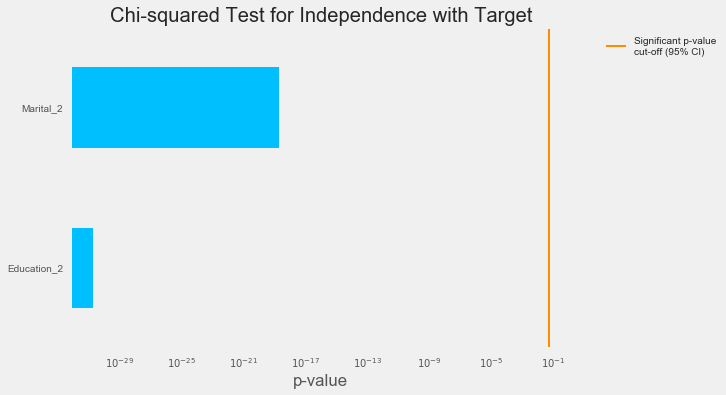


Reject null hypothesis - apparent association with target:
['Education_2', 'Marital_2']


In [10]:
# Categorical vs Categorical - chi squared test of independence

print('\nChi-squared Test for Independence:')
chi_square_test = stats.chi_squared(example_df, target_col_str='Y_2')

failed_chi = chi_square_test.loc[chi_square_test['p_value'] >= 0.05]
failed_chi_f = failed_chi.index.tolist()
if len(failed_chi_f) > 0:    
    print('\nAccept null hypothesis - no apparent association with target:')
    print(failed_chi_f)

passed_chi = chi_square_test.loc[chi_square_test['p_value'] < 0.05]
passed_chi_f = passed_chi.index.tolist()
if len(passed_chi_f) > 0:  
    print('\nReject null hypothesis - apparent association with target:')
    print(passed_chi_f)

invalid_chi = chi_square_test.loc[chi_square_test['p_value'].isnull()]
invalid_chi_f = invalid_chi.index.tolist()
if len(invalid_chi_f) > 0:  
    print('\nDid not meet assumptions for test (>20% of expected counts <5):')
    print(invalid_chi_f)
# need to divert these to another test (e.g. Fishers Exact)

#### Visual Analysis

The below plots the distribution of each categorical feature, as well as the distribution by the target. As before, visually analysing the features can help you better understand the data and identify data issues.

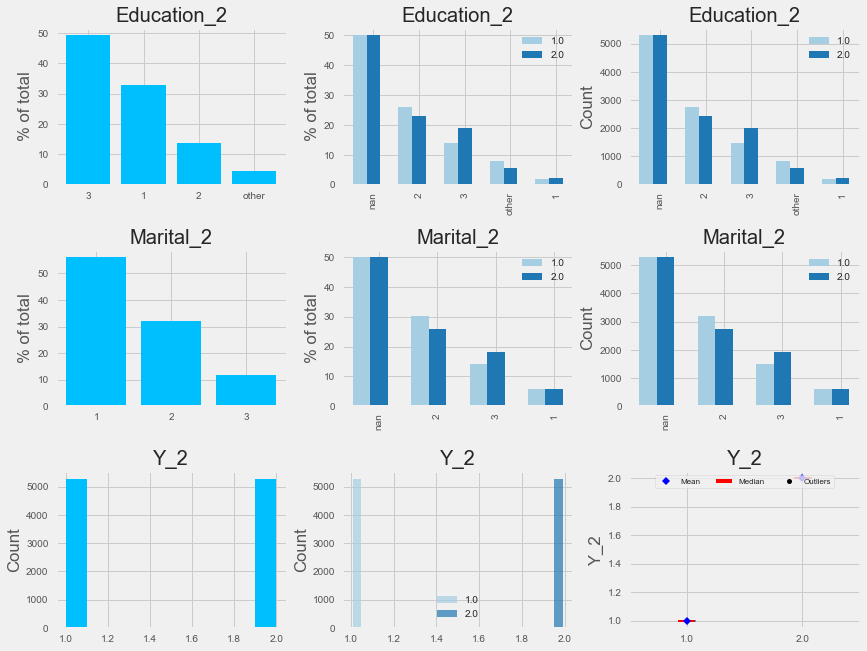

In [11]:
# Visual analysis of Categorical Features

top_categorical_f = passed_chi_f + invalid_chi_f + ['Y_2']

categorical_df_p = example_df[top_categorical_f]
stats.plot_features(df=categorical_df_p, target_col_str='Y_2')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()